# 2.5 - Análise de Qualidade do Grafo (SINKT)

Este notebook realiza um diagnóstico técnico da saúde estrutural do grafo de conhecimento extraído. O objetivo é validar a topologia antes de prosseguir para etapas de consumo (Student Modeling/RAG).

**Foco da Análise:**
1. **Métricas Globais:** Densidade, volume e distribuição de tipos.
2. **Conectividade:** Identificação de nós órfãos e ilhas isoladas.
3. **Integridade Lógica:** Detecção de ciclos em relações hierárquicas e loops.
4. **Topologia:** Identificação de Raízes (Conceitos base) e Folhas (Conceitos finais).

---

**Setup e Configuração:** Inicializa o ambiente, importando ferramentas de análise de grafos e visualização de dados, e define os caminhos dos arquivos.

In [1]:
!pip install -q networkx pandas matplotlib seaborn 

import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Configuração de Plotagem
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# --- CAMINHOS ATUALIZADOS PARA ESTRUTURA v2 ---
# Analisa o resultado da Fase 1/2 (Extração Inicial)
INPUT_FOLDER = "output/01_extraction"
CONCEPTS_FILE = f"{INPUT_FOLDER}/concepts_map.json"
RELATIONS_FILE = f"{INPUT_FOLDER}/relations_initial.json"

# Salva o relatório na mesma pasta
REPORT_FILE = f"{INPUT_FOLDER}/graph_quality_report.json"

## 1. Carregamento e Construção do Grafo

**Construção do Grafo:** Carrega os dados brutos e instancia o objeto grafo (MultiDiGraph) usando NetworkX, preparando a estrutura para análise.

In [2]:
def load_graph_data():
    try:
        with open(CONCEPTS_FILE, 'r', encoding='utf-8') as f:
            nodes_data = json.load(f)
        with open(RELATIONS_FILE, 'r', encoding='utf-8') as f:
            edges_data = json.load(f)
        return nodes_data, edges_data
    except FileNotFoundError as e:
        print(f"❌ Erro: Arquivo não encontrado - {e}")
        return [], []

nodes_list, edges_list = load_graph_data()

# Construção do MultiDiGraph (Permite múltiplas arestas entre nós, ex: IS_A e RELATED)
G = nx.MultiDiGraph()

# Adicionar Nós
for node in nodes_list:
    # Garantir que usamos apenas nós válidos (não NOISE, se ainda houver)
    if node.get('tipo') != 'NOISE':
        G.add_node(node['nome'], tipo=node.get('tipo', 'UNKNOWN'), chapter=node.get('capitulo_origem', ''))

# Adicionar Arestas
for edge in edges_list:
    if G.has_node(edge['source']) and G.has_node(edge['target']):
        G.add_edge(
            edge['source'], 
            edge['target'], 
            type=edge['type'], 
            explanation=edge.get('explanation', '')
        )
    else:
        # Logar arestas quebradas (source ou target inexistentes)
        pass

print(f"✅ Grafo Construído:")
print(f"   - Nós: {G.number_of_nodes()}")
print(f"   - Arestas: {G.number_of_edges()}")

✅ Grafo Construído:
   - Nós: 216
   - Arestas: 207


## 2. Métricas Gerais e Distribuições

**Métricas Globais:** Calcula a densidade do grafo e gera gráficos de distribuição para os tipos de conceitos e tipos de relações presentes.

Densidade do Grafo: 0.00446

 Distribuição de Tipos de Nós:
   - COMANDO: 78
   - CONCEITO_TEORICO: 42
   - SISTEMA_ARQUIVOS: 39
   - SHELL_SCRIPT: 29
   - FERRAMENTA: 12
   - REDE: 11
   - HARDWARE: 5

🔗 Distribuição de Tipos de Relações:
   - USE: 83
   - RELATED: 75
   - PART_OF: 31
   - IS_A: 18


/tmp/ipykernel_21396/812684938.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(node_type_counts.keys()), y=list(node_type_counts.values()), ax=ax[0], palette="viridis")
/tmp/ipykernel_21396/812684938.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(edge_type_counts.keys()), y=list(edge_type_counts.values()), ax=ax[1], palette="magma")


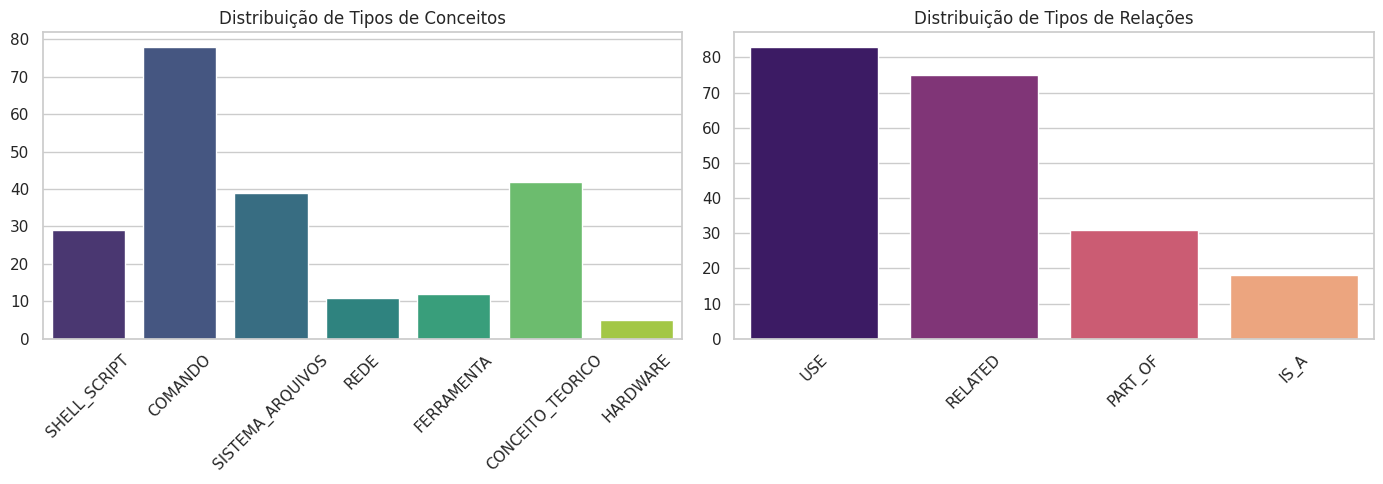

In [3]:
# Densidade
density = nx.density(G)

# Distribuição de Tipos de Nós
node_types = [data.get('tipo', 'UNKNOWN') for _, data in G.nodes(data=True)]
node_type_counts = Counter(node_types)

# Distribuição de Tipos de Relações
edge_types = [data.get('type', 'UNKNOWN') for _, _, data in G.edges(data=True)]
edge_type_counts = Counter(edge_types)

print(f"Densidade do Grafo: {density:.5f}")
print("\n Distribuição de Tipos de Nós:")
for t, c in node_type_counts.most_common():
    print(f"   - {t}: {c}")

print("\n🔗 Distribuição de Tipos de Relações:")
for t, c in edge_type_counts.most_common():
    print(f"   - {t}: {c}")

# Plotar Distribuições
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=list(node_type_counts.keys()), y=list(node_type_counts.values()), ax=ax[0], palette="viridis")
ax[0].set_title("Distribuição de Tipos de Conceitos")
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(x=list(edge_type_counts.keys()), y=list(edge_type_counts.values()), ax=ax[1], palette="magma")
ax[1].set_title("Distribuição de Tipos de Relações")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Análise de Conectividade
Verificar se o grafo é coeso ou fragmentado.

**Análise de Conectividade:** Avalia a coesão do grafo, identificando componentes desconectados e contando nós isolados (órfãos) que precisam de atenção.

In [4]:
# Componentes Fracamente Conectados (Ignora direção das arestas para ver 'ilhas')
weakly_connected = list(nx.weakly_connected_components(G))
num_components = len(weakly_connected)
largest_component_size = len(max(weakly_connected, key=len)) if weakly_connected else 0

# Nós Órfãos (Grau 0 - Sem entrada nem saída)
orphans = [n for n, d in G.degree() if d == 0]

print(f"Componentes Conectados (Fracos): {num_components}")
print(f"   - Tamanho do Maior Componente: {largest_component_size} nós")
print(f"   - Número de Nós Órfãos (Isolados): {len(orphans)}")

if len(orphans) > 0:
    print(f"   ⚠️ Exemplos de Órfãos: {orphans[:10]}...")

Componentes Conectados (Fracos): 46
   - Tamanho do Maior Componente: 70 nós
   - Número de Nós Órfãos (Isolados): 31
   ⚠️ Exemplos de Órfãos: ['-h', '-r', '/lost+found', '/run', '/usr/share/man/', 'cat', 'cp', 'DEB', 'hexdump', 'HOME']...


## 4. Topologia: Raízes e Folhas (Dependências)
Para esta análise, consideramos apenas arestas que implicam dependência ou hierarquia forte:
- `PREREQUISITE`
- `IS_A`
- `PART_OF`

Ignoramos `RELATED` e `USE` para definir estritamente o fluxo de aprendizado.

**Identificação de Raízes e Folhas:** Mapeia a estrutura hierárquica do grafo, identificando conceitos base (raízes) e conceitos finais (folhas) com base nas relações de dependência.

In [5]:
DEPENDENCY_TYPES = {'PREREQUISITE', 'IS_A', 'PART_OF'}

# Criar subgrafo apenas com arestas de dependência para análise de fluxo
def filter_dependency_edges(u, v, k):
    return G[u][v][k].get('type') in DEPENDENCY_TYPES

G_dep = nx.subgraph_view(G, filter_edge=filter_dependency_edges)

# Raízes: In-degree 0 no grafo de dependências (Conceitos que não exigem nada prévio NO GRAFO)
roots = [n for n, d in G_dep.in_degree() if d == 0]

# Folhas: Out-degree 0 no grafo de dependências (Conceitos que não são base para outros NO GRAFO)
leaves = [n for n, d in G_dep.out_degree() if d == 0]

print(f"Raízes (Conceitos Base): {len(roots)}")
print(f"   Exemplos: {roots[:10]}")

print(f"\n Folhas (Conceitos Finais): {len(leaves)}")
print(f"   Exemplos: {leaves[:10]}")

Raízes (Conceitos Base): 196
   Exemplos: ['$PATH', '*', '--help', '-?', '-a', '-amin', '-atime', '-B', '-C', '-d']

 Folhas (Conceitos Finais): 173
   Exemplos: ['$PATH', '*', '--help', '-?', '-a', '-amin', '-atime', '-B', '-C', '-d']


## 5. Detecção de Anomalias Estruturais (Crítico)
Ciclos em arestas de dependência quebram a lógica de pré-requisitos (A precisa de B que precisa de A).
Auto-loops são redundâncias que podem confundir o modelo.

**Detecção de Anomalias:** Verifica a integridade lógica do grafo, buscando por ciclos em relações de dependência (o que quebraria a precedência pedagógica) e auto-loops.

In [6]:
# 1. Auto-loops
self_loops = list(nx.selfloop_edges(G))
has_self_loops = len(self_loops) > 0

print(f"🔄 Auto-loops detectados: {len(self_loops)}")
if has_self_loops:
    print(f"   - Detalhes: {self_loops}")

# 2. Ciclos (Apenas em Dependências)
# nx.simple_cycles requer DiGraph (não MultiDiGraph), mas sub_graph_view mantém o tipo.
# Convertendo para DiGraph simples para detecção de ciclos (perde arestas paralelas, mantendo se houver pelo menos uma)
G_dep_simple = nx.DiGraph(G_dep)

try:
    cycles = list(nx.simple_cycles(G_dep_simple))
    has_cycles = len(cycles) > 0
    
    print(f"\n⭕ Ciclos em Dependências ({', '.join(DEPENDENCY_TYPES)}): {len(cycles)}")
    if has_cycles:
        print("   ⚠️ ALERTA: Ciclos encontrados! Isso quebra a lógica de Knowledge Tracing.")
        for idx, cycle in enumerate(cycles[:5]):
            print(f"      {idx+1}. {' -> '.join(cycle)} -> {cycle[0]}")
except Exception as e:
    print(f"Erro na detecção de ciclos: {e}")
    cycles = []

🔄 Auto-loops detectados: 0

⭕ Ciclos em Dependências (PART_OF, PREREQUISITE, IS_A): 0


## 6. Visualização de Distribuição de Graus
Identificar "Hubs" (conceitos centrais) e a dispersão de conectividade.

**Análise de Graus:** Plota histogramas para visualizar a distribuição de conectividade dos nós (graus de entrada e saída), ajudando a identificar hubs e conceitos centrais.

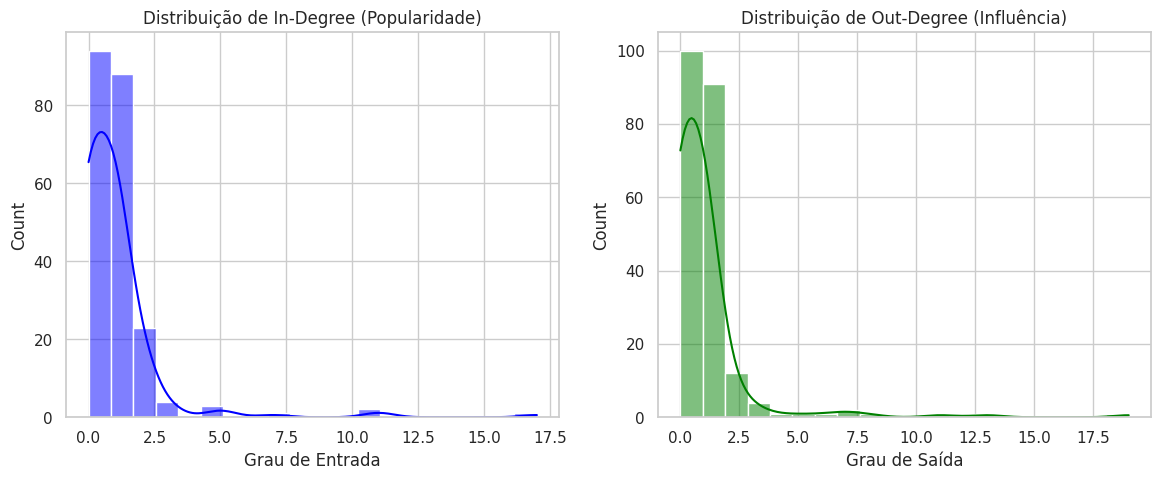

In [7]:
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(in_degrees, bins=20, kde=True, ax=ax[0], color='blue')
ax[0].set_title("Distribuição de In-Degree (Popularidade)")
ax[0].set_xlabel("Grau de Entrada")

sns.histplot(out_degrees, bins=20, kde=True, ax=ax[1], color='green')
ax[1].set_title("Distribuição de Out-Degree (Influência)")
ax[1].set_xlabel("Grau de Saída")

plt.show()

## 7. Exportação do Relatório

**Exportação do Relatório:** Salva todas as métricas calculadas, anomalias detectadas e listas de interesse (raízes, folhas, órfãos) em um arquivo JSON consolidado.

In [8]:
report = {
    "metrics": {
        "total_nodes": G.number_of_nodes(),
        "total_edges": G.number_of_edges(),
        "density": density,
        "connected_components": num_components,
        "orphans_count": len(orphans),
        "roots_count": len(roots),
        "leaves_count": len(leaves)
    },
    "anomalies": {
        "self_loops": list(self_loops),
        "cycles_in_dependencies": cycles
    },
    "lists": {
        "orphans": orphans,
        "roots": roots,
        "leaves": leaves
    }
}

with open(REPORT_FILE, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=4, ensure_ascii=False)

print(f"📄 Relatório completo salvo em: {REPORT_FILE}")

📄 Relatório completo salvo em: output/01_extraction/graph_quality_report.json
